**작성자** : 김종원, **업데이트 일자** : 2021.03.09


# 항공사 고객 만족도 예측

## 목적
항공사의 만족도 조사 정보들을 담은 데이터를 통해 각 응답자의 만족 여부를 예측하는 문제에 **단변량 이변량 탐색**을 해보면서 단변량 탐색과 이변량 탐색에 대해 이해하고자 합니다.

## 데이터 출처 :
https://dacon.io/competitions/official/235871/overview/description

## 모듈 임포트

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm

# 한글 적용.
import platform
import seaborn as sns 
from matplotlib import font_manager, rc 

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system. sorry")

In [2]:
# 시각화 팔레트 설정.
color_map1 = ["#1C4AA6", "#366CD9","#579AF2","#77ACF2", "#9BCAF2"]
color_map2 = ["#90A681", "#A67458","#402116","#8C5946", "#F2E4E4"]

## 데이터 로드

**데이터 설명**

* id : 샘플 아이디
* Gender : 성별
* Customer Type : Disloyal 또는 Loyal 고객
* Age : 나이
* Type of Travel : Business 또는 Personal Travel
* Class : 등급
* Flight Distance : 비행 거리
* Seat comfort : 좌석 만족도
* Departure/Arrival time convenient : 출발/도착 시간 편의성 만족도
* Food and drink : 식음료 만족도
* Gate location : 게이트 위치 만족도
* Inflight wifi service : 기내 와이파이 서비스 만족도
* Inflight entertainment : 기내 엔터테인먼트 만족도
* Online support : 온라인 지원 만족도
* Ease of Online booking : 온라인 예매 편리성 만족도
* On-board service : 탑승 서비스 만족도
* Leg room service : Leg room 서비스 만족도
* Baggage handling : 수하물 처리 만족도
* Checkin service : 체크인 서비스 만족도
* Cleanliness : 청결도 만족도
* Online boarding : 온라인보딩 만족도
* Departure Delay in Minutes : 출발 지연 시간
* Arrival Delay in Minutes : 도착 지연 시간
* target : 만족 여부

In [3]:
# 데이터 경로 설정.
path = "https://github.com/JONWON2/-EDA/files/8212472/train.csv"

In [4]:
data = pd.read_csv(path)
print(data.shape)
data.head()

(3000, 24)


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,...,4,5,4,4,4,5,4,0,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,...,5,5,4,2,1,5,2,18,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,...,4,4,4,4,5,4,3,0,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,...,3,2,4,5,3,4,3,10,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,...,4,4,4,4,4,4,5,0,0.0,1


# 데이터 이해

## 1. 데이터 탐색(EDA & CDA)

* 전체 데이터 정보(null값 유무, 데이터 타입 등) 확인

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

전체 컬럼에 대해서 null 값이 존재하는 컬럼은 없다.

* 기초 통계량

In [6]:
data.describe().iloc[1:,1:].style.background_gradient(cmap='PuBu')

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
mean,39.203000,1983.079333,2.863333,3.009667,2.874333,3.016667,3.259667,3.352333,3.505000,3.488000,3.497000,3.485000,3.728667,3.370000,3.728667,3.356333,15.634333,15.922000,0.556000
std,15.108802,1028.109117,1.394981,1.519543,1.431511,1.294713,1.322683,1.352826,1.310680,1.302211,1.283436,1.294218,1.154190,1.258158,1.161678,1.294057,45.083228,45.203411,0.496937
min,7.000000,52.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1348.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,39.000000,1937.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,1.000000
75%,51.000000,2547.250000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,80.000000,6882.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.000000,1115.000000,1.000000


대부분 수치가 낮다는 것을 알 수 있다 최대 5. 그래서 데이터를 이해하고자 생각을 해보았을때, 고객 만족도를 조사하기 위해 설문지에 대해서 체크하여 점수를 나타낸것으로 추정된다.그렇기에 수치형 데이터보다 범주형 데이터가 많이 분포된 데이터라고 판단하고자 합니다.

## Target 값인 고객의 만족여부에 대해서 단변량 탐색
* 단별량 분석

In [7]:
palette = sns.color_palette("bright")
custom_palette = sns.color_palette("Paired", 9)

1    1668
0    1332
Name: target, dtype: int64


C:\Users\User\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


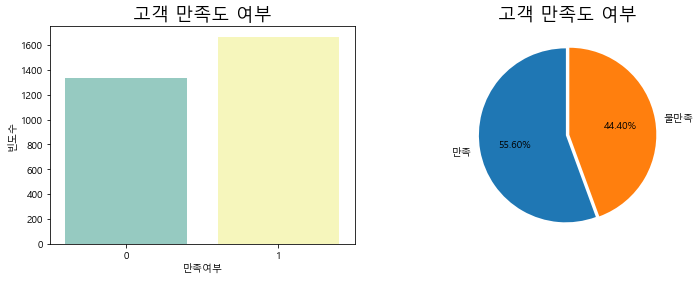

In [8]:
print(data["target"].value_counts())
# 색상 지정
# sns.countplot(data["target"],color=color_map1[2])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# seaborn 안에 있는 색상 지정
custom_colors = sns.color_palette("Set3", 10)
# custom_colors = sns.color_palette("coolwarm", 10)
sns.countplot(data["target"],palette=custom_colors)
plt.title("고객 만족도 여부",size= 18)

plt.xlabel("만족여부")
plt.ylabel("빈도수")

plt.subplot(1,2,2)
plt.title("고객 만족도 여부",size= 18)
table = data["target"].value_counts()
plt.pie(table.values,
    labels=["만족","불만족"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02])

plt.show()

해당 항공사를 이용하는 전체 고객(3천명) 중 약 55.6%가 만족했습니다.

그럼 3천명 고객 중 55.6%가 왜 만족을 하였는지 데이터를 통해 이해하고자 합니다.

## 가설 수립 및 검정

### 비행거리에 대한 단별량 분석

그래서 제일 먼저 비행 거리에 따라 만족도가 어떻게 평가가 되는지 가설을 세우고 EDA 및 CDA를 진행합니다.

> 가설(대립가설) : 비행 거리에 따라 만족도 여부에 차이가 있을 것이다.


* **단별량 분석 -> 비행거리(숫자)**


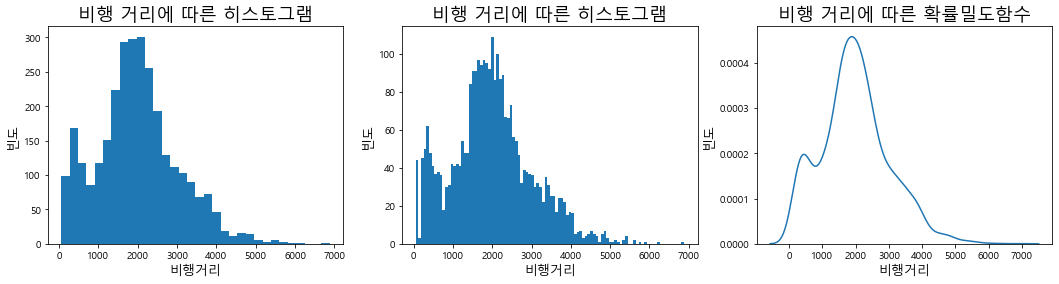

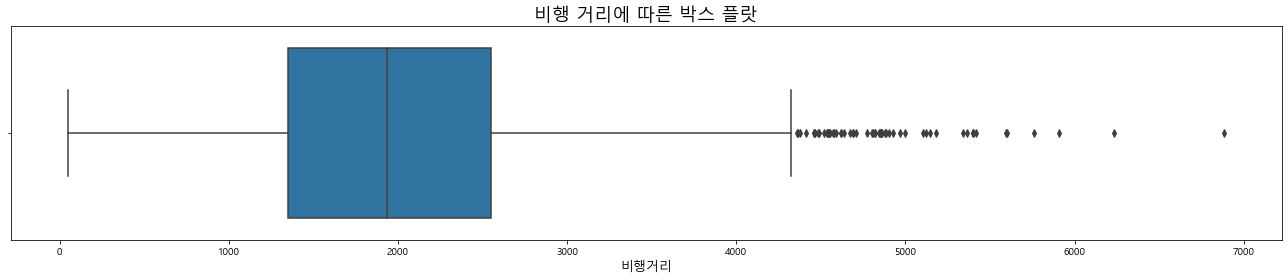

In [9]:
plt.figure(figsize= (18,4))
plt.subplot(1,3,1)
plt.hist(data["Flight Distance"],bins=32)
plt.title("비행 거리에 따른 히스토그램",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("비행거리",size = 13)


plt.subplot(1,3,2)
plt.hist(data["Flight Distance"],bins=100)
plt.title("비행 거리에 따른 히스토그램",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("비행거리",size = 13)

plt.subplot(1,3,3)
sns.kdeplot(data=data ,x= "Flight Distance")
plt.title("비행 거리에 따른 확률밀도함수",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("비행거리",size = 13)

plt.show()
plt.figure(figsize= (18,4))
sns.boxplot(data=data ,x= "Flight Distance")
plt.title("비행 거리에 따른 박스 플랏",size= 18)
plt.xlabel("비행거리",size = 13)

plt.tight_layout()
plt.show()

비행거리에 대한 히스토그램의 bins(구간)를 32로 두고 시각화하였을때 두개의 봉오리가 보여서, 구간을 100으로 하여 결과를 보았을때 짧은 거리를 이동하는 고객과 중장거리 장거리 여행을 가는 고객이 존재한다는 것을 파악하게 되었다. 그렇기에 해당 컬럼을 구간을 나눠서 단거리 여행, 중단거리 여행, 중장거리 여행, 장거리 여행으로 나누어 분석해도 좋을 것으로 판단된다.

### 이변량 분석 : X(비행거리) -> Y(만족도)

가설(대립가설) : 비행 거리에 따라 만족도 여부에 차이가 있을 것이다.

* 데이터 유형
    - X : 숫자 
    - Y : 범주
    
* 분석 방법
    - 시각화 
        - 밀도 함수 또는 히스토그램
    - 수치화
        - 로지스틱 회귀 모델

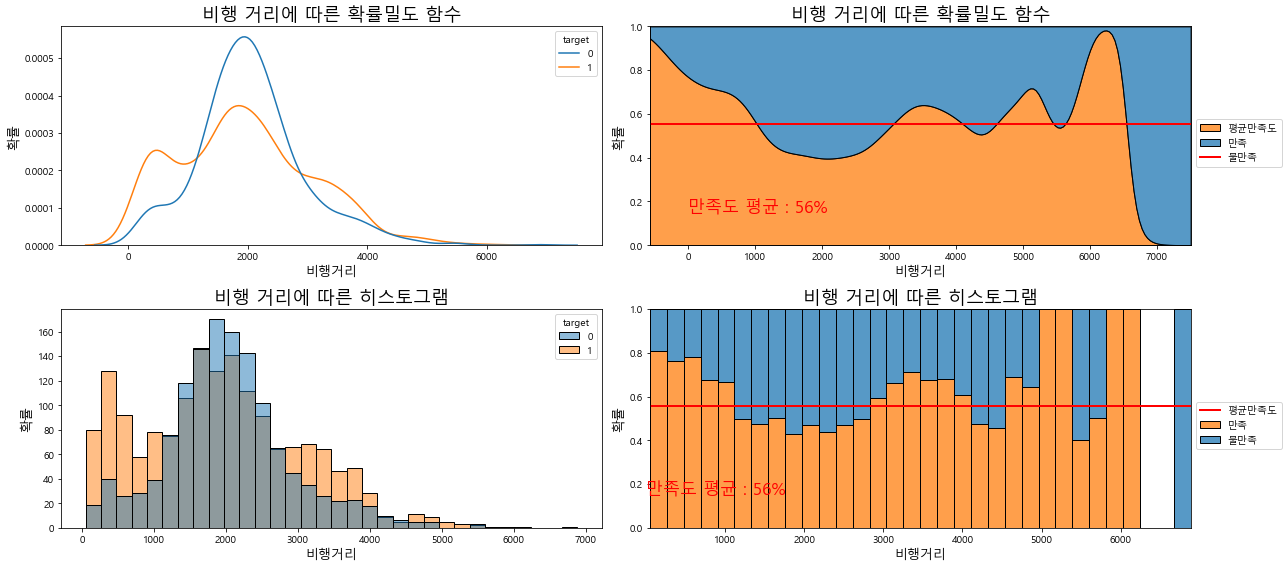

In [10]:
mean_val = data["target"].mean()

plt.figure(figsize= (18,8))
plt.subplot(2,2,1)
sns.kdeplot(data = data, x= "Flight Distance",hue="target",common_norm=False)
plt.title("비행 거리에 따른 확률밀도 함수",size= 18)
plt.ylabel("확률",size = 13)
plt.xlabel("비행거리",size = 13)


plt.subplot(2,2,2)
sns.kdeplot(data = data, x= "Flight Distance",hue="target",common_norm=False,multiple='fill')
plt.axhline(mean_val,color='r',linewidth=2)
plt.text(1,0.15,f"만족도 평균 : {mean_val*100:.0f}%",color='r',size=17)

plt.title("비행 거리에 따른 확률밀도 함수",size= 18)
plt.ylabel("확률",size = 13)
plt.xlabel("비행거리",size = 13)
plt.legend(labels= ["평균만족도",'만족','불만족'],bbox_to_anchor=(1, 0.6))


plt.subplot(2,2,3)
sns.histplot( data=data, x="Flight Distance" , hue="target", bins = 32)
plt.title("비행 거리에 따른 히스토그램",size= 18)
plt.ylabel("확률",size = 13)
plt.xlabel("비행거리",size = 13)


plt.subplot(2,2,4)
sns.histplot( data=data, x="Flight Distance" , hue="target", bins = 32, multiple='fill')
plt.axhline(mean_val,color='r',linewidth=2)
plt.text(1,0.15,f"만족도 평균 : {mean_val*100:.0f}%",color='r',size=17)
plt.title("비행 거리에 따른 히스토그램",size= 18)
plt.ylabel("확률",size = 13)
plt.xlabel("비행거리",size = 13)
plt.legend(labels= ["평균만족도",'만족','불만족'],bbox_to_anchor=(1, 0.6))

plt.tight_layout()
plt.show()

* 거리가 약 1000km까지는 만족도가 높고, 1000~ 2800까지는 만족도가 줄어든다. 3000~ 4000까지 만족도가 오르며 4200~4600까지는 만족도가 떨어지며, 4600이후 부터 만족도가 상승한다.

* 추가 분석 고려 사항
아까 단별량 분석 시 거리에 따른 그룹을 묶어서 만족여부를 분석하고자 하였으나, 해당 그래프를 보고 하나더 고려해볼 만한 정보를 발견한 것 같다. 비행 거리가 짧거나, 중장기 여행이거나 장기 여행일때 만족도가 높습니다. 그런데 여행을 가기 위해서는 비행기를 타야합니다. 그러면 비행기들은 특정 노선을 가지고 있을 것이며 특정 노선에 대해서 서비스가 만족이 떨어지는게 아닌가 고민을 하게 되었습니다.

### 분석 결과
비행 거리에 따른 만족여부의 차이는 존재하고, 이 존재를 더 명확하게 알아내기 위해 데이터를 그룹핑(재그룹) 해볼 가치가 있어 보입니다.
* 가설
    1. 거리를 구간(단거리, 중단거리, 중장거리, 장거리) 4구간으로 나눠서 만족여부에 차이가 있는지 이변량 분석을 하고자 합니다.
    2. 비행기별 비행 거리에 대한 평균을 계산하여 그룹핑 후 중장거리에 대해 왜 만족도가 떨어지는지 파악. -> 데이터가 없음..

### 추가 분석 -> 비행거리 유형에 따른 만족도 분석
    1. 데이터 그룹핑
    2. 비행거리 유형에 따른 단별량 분석
    3. 이변량 분석 : X(비행거리 그룹) -> Y(만족도)


#### 데이터 그루핑

In [11]:
data.loc[data["Flight Distance"] <= 1100,"Flight Distance_Group"] =1
data.loc[(data["Flight Distance"] > 1100) & (data["Flight Distance"] <= 2800) ,"Flight Distance_Group"] =2
data.loc[(data["Flight Distance"] > 2800) & (data["Flight Distance"] <= 4000) ,"Flight Distance_Group"] =3
data.loc[data["Flight Distance"] >4000,"Flight Distance_Group"] =4

####  비행거리 유형에 따른 단별량 분석

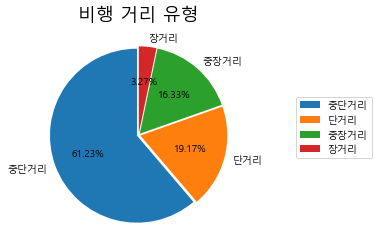

In [12]:
plt.title("비행 거리 유형",size= 18)
table = data["Flight Distance_Group"].value_counts()
plt.pie(table.values,
        labels=["중단거리","단거리","중장거리","장거리"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02, 0.02, 0.02])
plt.legend(bbox_to_anchor=(1.2, 0.7))
plt.show()

#### 이변량 분석 : X(비행거리 그룹) -> Y(만족도)

비행 거리 유형에 따라 만족여부에 차이가 있을것이다 를 입증하고자 한다.
* 데이터 유형
    - X : 범주
    - Y : 범주
* 분석 방법
    * 시각화
        - 100% Stacked bar plot, mosaic plot
    * 수치화
        - 카이제곱검정

전체 평균 만족도 : 0.556


Flight Distance_Group,1.0,2.0,3.0,4.0
target,,,,
0,0.255652,0.529124,0.35102,0.418367
1,0.744348,0.470876,0.64898,0.581633


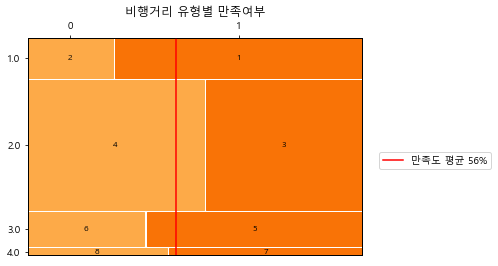

In [13]:
table = pd.crosstab(data["target"],data["Flight Distance_Group"], normalize="columns")
print(f"전체 평균 만족도 : {mean_val}")
display(table)


# 모자익 그래프의 색상 설정.
props = {}
props[('1.0', '1')] = {'color': 'xkcd:orange'}
props[('1.0','0')] = {'color': 'xkcd:light orange'}
props[('2.0', '1')] = {'color': 'xkcd:orange'}
props[('2.0','0')] = {'color': 'xkcd:light orange'}
props[('3.0', '1')] = {'color': 'xkcd:orange'}
props[('3.0','0')] = {'color': 'xkcd:light orange'}
props[('4.0', '1')] = {'color': 'xkcd:orange'}
props[('4.0','0')] = {'color': 'xkcd:light orange'}

# 텍스트 정보 설정.
label_name = {}
label_name[('1.0', '1')] = "1"
label_name[('1.0','0')] = "2"
label_name[('2.0', '1')] = "3"
label_name[('2.0','0')] = "4"
label_name[('3.0', '1')] = "5"
label_name[('3.0','0')] = "6"
label_name[('4.0', '1')] = "7"
label_name[('4.0','0')] = "8"
    

mosaic(data.sort_values(['Flight Distance_Group','target'],
       ascending=[False,True]), 
       ['Flight Distance_Group','target'],
       gap=0.01,
       title='비행거리 유형별 만족여부',
       properties=props, 
       horizontal=False , 
       labelizer=lambda k: label_name[k],
       axes_label=True
      )

plt.axvline(1- data['target'].mean(), color = 'r')

plt.legend([f"만족도 평균 {data['target'].mean() * 100:.0f}%"], bbox_to_anchor=(1.4, 0.5))
plt.show()

차이가 있는 것으로 확인됩니다. 그래서 수치화를 시켜서 차이가 있는지 검증을 진행합니다.

* 카이제곱검정

In [14]:
table = pd.crosstab(data["target"],data["Flight Distance_Group"])

# 카이제곱검정
result = spst.chi2_contingency(table)
print(f'카이제곱통계량 {result[0]:.5f}  p-value : {result[1]}')

카이제곱통계량 153.96960  p-value : 3.6675561683700214e-33


p_value(유의 확률)가 유의수준 0.05보다 작기에 귀무가설을 기각하고 **대립가설인 "비행 거리 유형에 따른 만족 여부에 차이가 있다" 가설을 채택합니다.**

---

나이가 많아지만 비행거리를 멀리 가는 것을 꺼려하는 분들이 존재한다. 그래서 나이가 증가하면 비행거리가 하락하는 관계라고 가설을 세우고 EDA 및 CDA를 진행하고자 합니다.

### 나이에 대한 단변량 분석


> 가설(대립가설) : 나이가 증가하면 비행거리가 하락하는 관계일 것이다


* **단별량 분석 -> 나이(숫자)**

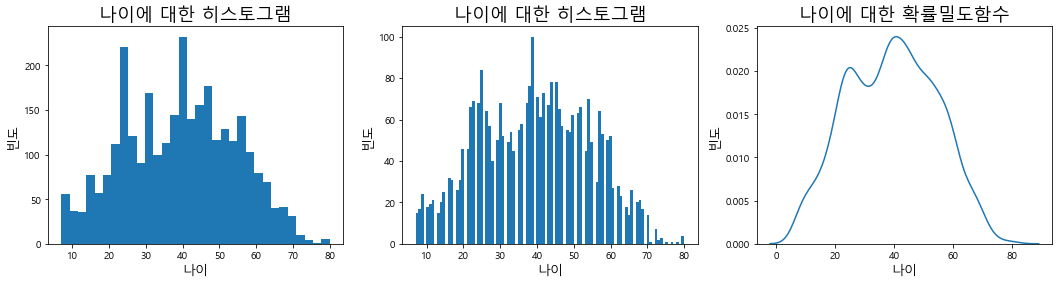

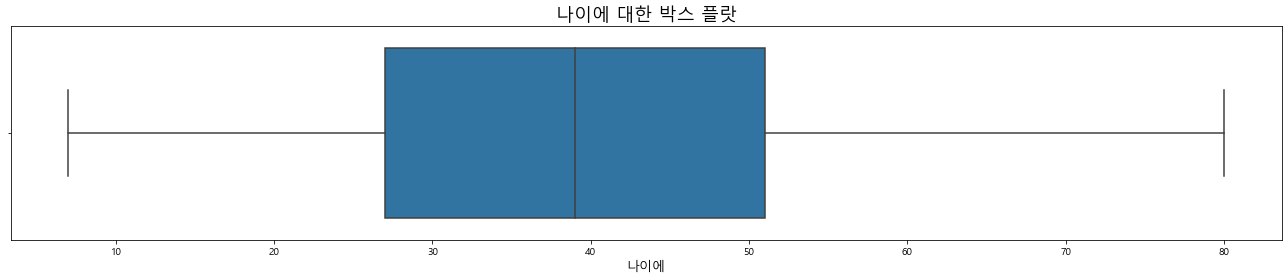

In [15]:
plt.figure(figsize= (18,4))
plt.subplot(1,3,1)
plt.hist(data["Age"],bins=32)
plt.title("나이에 대한 히스토그램",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("나이",size = 13)


plt.subplot(1,3,2)
plt.hist(data["Age"],bins=100)
plt.title("나이에 대한 히스토그램",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("나이",size = 13)

plt.subplot(1,3,3)
sns.kdeplot(data=data ,x= "Age")
plt.title("나이에 대한 확률밀도함수",size= 18)
plt.ylabel("빈도",size = 13)
plt.xlabel("나이",size = 13)

plt.show()
plt.figure(figsize= (18,4))
sns.boxplot(data=data ,x= "Age")
plt.title("나이에 대한 박스 플랏",size= 18)
plt.xlabel("나이에",size = 13)

plt.tight_layout()
plt.show()

고객층이 20대 고객과 30대 후반에서 40대 후반 고객까지 항공사를 주로 이용하는 고객으로 추정된다.

### 이변량 분석 : X(비행거리) -> Y(만족도)¶
가설(대립가설) : 나이가 증가하면 비행거리가 하락하는 관계일 것이다

* 데이터 유형
    - X : 숫자 
    - Y : 숫자
    
* 분석 방법
    - 시각화
        - scatter or scatterplot or jointplot
    - 수치화
        - 상관관계 -> 선형성의 관계인지 파악하고자 함.

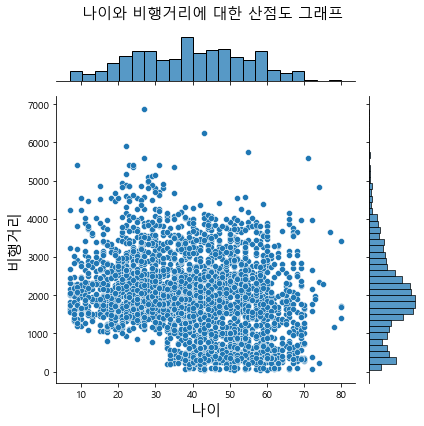

In [16]:
# plt.scatter(data["Age"],data["Flight Distance"],  color= color_map1[4])
# plt.title("나이와 비행거리에 대한 산점도 그래프", size= 18)

# plt.xlabel("나이",size = 15)
# plt.ylabel("비행거리",size = 15)
# plt.show()
p = sns.jointplot(data = data , x="Age", y ="Flight Distance")
# p.fig.suptitle("나이와 비행거리에 대한 산점도 그래프",fontweight='bold',fontsize=15)
p.fig.suptitle("나이와 비행거리에 대한 산점도 그래프",fontsize=15)
p.fig.subplots_adjust(top=0.95)
p.ax_joint.set_xlabel('나이',fontsize=15)
p.ax_joint.set_ylabel('비행거리',fontsize=15)
p.fig.tight_layout()
plt.show()

30세 초반 이전에는 1000km 이상 비행을 짧게 가는 데이터가 존재하지 않는다. 하지만 30대 초반 후에는 1000km 이하 데이터가 많이 존재한다. 위 데이터를 통해 나이가 많은 수록 비행거리가 짧아 진다 라는 관계를 입증하기가 어렵다. 그렇기에 해당 결과를 수치화하여 가설을 검증하고자 합니다.

* 상관관계

In [17]:
spst.pearsonr(data["Age"],data["Flight Distance"])

(-0.2446482778905889, 3.9201659015322624e-42)

음의 산관관계를 가지며, p_value값은 0.05보다 작기에 나이가 많아질 수록 비행거리는 짧아진다 라는 가설이 채택되게 된다. 하지만, 이 정보가 직선관계가 유의미한거지, 데이터를 시각화 하였을때, 그 결과가 파악하기가 어렵다. 그렇기에 추가적인 분석을 하고자 합니다.

나이를 30대 초반 전, 후로 나누어 30대 전후에 따라 비행거리의 차이가 있는지 파악하고자 합니다.

### 추가 분석
    1. 데이터 그룹핑
    2. 30대 전후 그룹에 대한 단변량 분석
    3. 이변량 분석 : X(30대 전후) -> Y(비행거리)

#### 데이터 그룹핑

In [18]:
data.loc[data["Age"] < 34,"Age_30"] = 0
data.loc[data["Age"] >= 34,"Age_30"] = 1

#### 30대 전후 그룹에 대한 단변량 분석

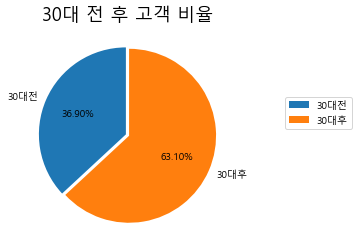

In [19]:
plt.title("30대 전 후 고객 비율",size= 18)
table = data["Age_30"].value_counts().sort_index()
plt.pie(table.values,
        labels=["30대전","30대후"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02])
plt.legend(bbox_to_anchor=(1.2, 0.7))
plt.show()

약 37%가 30대 전 고객 비율이며, 약 63%가 30대 후 고객비율이다.

#### 이변량 분석 : X(30대 전후) -> Y(비행거리)¶
가설(대립가설) : 30대 전후에 따라 비행거리의 차이가 있을 것이다.

* 데이터 유형
    - X : 범주(2개)
    - Y : 숫자
    
* 분석 방법
    - 시각화 
        - barplot
    - 수치화
        - t-검정

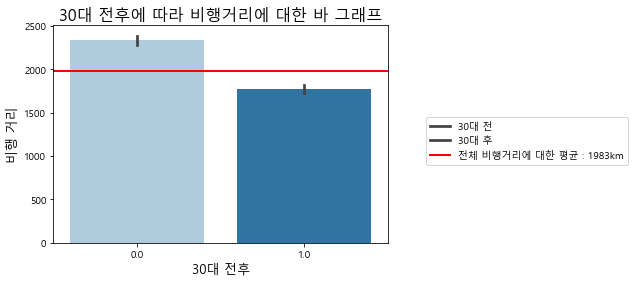

In [20]:
sns.barplot(data=data, x="Age_30",y="Flight Distance",palette=custom_palette)

plt.axhline(data["Flight Distance"].mean(),color='r',linewidth=2)

plt.title("30대 전후에 따라 비행거리에 대한 바 그래프",size= 16)
plt.xlabel("30대 전후",fontsize = 13)
plt.ylabel("비행 거리",fontsize = 13)

plt.legend(labels= ["30대 전",'30대 후',f'전체 비행거리에 대한 평균 : {data["Flight Distance"].mean():.0f}km'],bbox_to_anchor=(1.1, 0.6))
plt.show()

각 범주별 95% 신뢰구간이 겹치지 않고 폭이 좁게 있다. 위 그래프를 보았을때, 두 신뢰구간이 겹치지 않기에 30대 전후에 따라 비행거리에 대한 차이가 있을 것이다 라고 보여진다.

이를 수치적으로 알아보기위해 t-검정을 시행한다.

In [21]:
s1 = data[data["Age_30"] ==0]["Flight Distance"]
s2 = data[data["Age_30"] ==1]["Flight Distance"]

In [22]:
spst.ttest_ind(s1,s2)

Ttest_indResult(statistic=14.804427565195056, pvalue=6.48227501417427e-48)

가설을 검증하기 위해 t 테스트를 진행하였고, 30대 전후에 따라 비행거리 차이가 있을 것이다. 라고 볼 수 있다.

### 식음료에 대한 만족도 단변량 분석

기내에 식음료 만족도에 따라서 비행거리에 차이가 있을것이다 라는 가설을 세워서 EDA 및 CDA를 진행하고자 합니다.

> 가설(대립가설) : 식음료 만족도에 따라서 비행거리에 차이가 발생할 것이다.

* **단변량 분석 : 식음료 만족도**

In [23]:
data["Food and drink"].unique()

array([3, 4, 1, 2, 0, 5], dtype=int64)

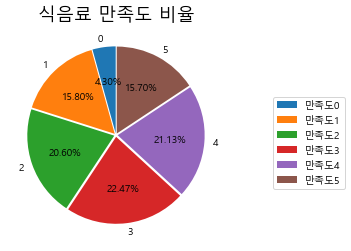

In [24]:
data["Food and drink"]

plt.title("식음료 만족도 비율",size= 18)
table = data["Food and drink"].value_counts().sort_index()
plt.pie(table.values,
        labels=["0","1","2","3","4","5"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
plt.legend(labels = ["만족도0","만족도1","만족도2","만족도3","만족도4","만족도5"],bbox_to_anchor=(1.2, 0.7))
plt.show()

만족도가 최대와 최소는 보통이고, 0인것은 극히 드물다. 또한 2,3,4는 만족도 비율이 비슷비슷합니다.

이변량 분석을 통해 위 식음료 만족도에 따라서 비행거리에 차이가 발생할 것이다. 라는 가설을 입증하고자 합니다.

### 이변량 분석 : X(음식 만족도) -> Y(비행거리)¶
가설(대립가설) : 식음료 만족도에 따라서 비행거리에 차이가 발생할 것이다

* 데이터 유형
    - X : 범주(6개)
    - Y : 숫자
    
* 분석 방법
    - 시각화 
        - barplot
    - 수치화
        - 분산분석

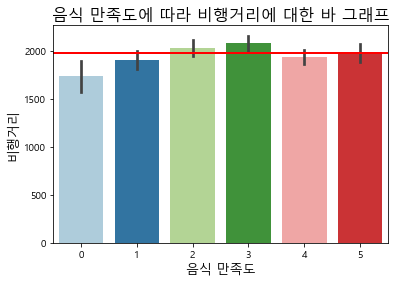

In [25]:
sns.barplot(data=data, x="Food and drink",y="Flight Distance",palette=custom_palette)

plt.axhline(data["Flight Distance"].mean(),color='r',linewidth=2)

plt.title("음식 만족도에 따라 비행거리에 대한 바 그래프",size= 16)

plt.xlabel("음식 만족도",fontsize = 13)
plt.ylabel("비행거리",fontsize = 13)

plt.show()

그래프를 보았을때, 0을 제외하고 큰 차이는 없는것으로 보여진다. 그러면 통계적으로 정말 유의미하지 않는지 가설검증을 하도록 하겠습니다.

* 분산분석

In [26]:
s1 = data.loc[ data["Food and drink"] == 0,]['Flight Distance']
s2 = data.loc[ data["Food and drink"] == 1,]['Flight Distance']
s3 = data.loc[ data["Food and drink"] == 2,]['Flight Distance']
s4 = data.loc[ data["Food and drink"] == 3,]['Flight Distance']
s5 = data.loc[ data["Food and drink"] == 4,]['Flight Distance']
s6 = data.loc[ data["Food and drink"] == 5,]['Flight Distance']

print(spst.f_oneway(s1,s2,s3,s4,s5,s6))

F_onewayResult(statistic=3.7158379060951425, pvalue=0.002349459505436465)


F 통계량을 구하여 p_value를 확인하니 0.002로 유의수준 0.05% 내 이기에 대립가설을 채택하지만 위 가설은 약한 차이가 발생한 것으로 판단된다.